In [4]:
# settings for LBP
import numpy as np
from numpy.testing import assert_equal
from skimage.transform import integral_image
import numpy as np
from skimage.feature import local_binary_pattern
import pandas as pd

X, Y = np.load('/Users/SMC/Downloads/X.npy'), np.load('/Users/SMC/Downloads/Y.npy')
X_test =np.load('/Users/SMC/Downloads/X_test.npy')

# X = X/255
# X_test = X_test/255
# normalization or not doesn't make much difference

radius = 4
n_points = 4*radius

METHOD = 'uniform'
lbp_train_1 = []
lbp_test_1 = []


for image in X: 
    lbp = local_binary_pattern(image, n_points, radius, METHOD)
    n_bins = int(lbp.max() + 1)
    (hist, _) = np.histogram(lbp.ravel(),bins=n_bins,range=(0, n_bins))
    # normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum())
    lbp_train_1.append(hist)
    
    
for image in X_test: 
    lbp = local_binary_pattern(image, n_points, radius, METHOD)
    n_bins = int(lbp.max() + 1)
    (hist, _) = np.histogram(lbp.ravel(),bins=n_bins,range=(0, n_bins))
    # normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum())
    lbp_test_1.append(hist)
    
    
lbp_train_array = np.asarray(lbp_train_1[:]) ## 
lbp_test_array = np.asarray(lbp_test_1[:]) ##
Y = np.asarray(Y[:])##
T_ts = np.eye(20)[Y]

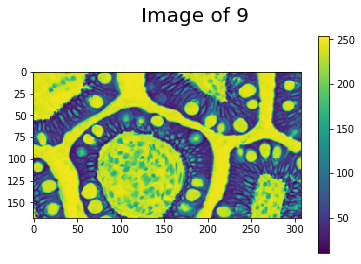

In [24]:
## For visulization of the images
import matplotlib.pyplot as plt
from random import randrange

rand = randrange(660)

fig = plt.figure()
fig.suptitle('Image of ' + str(Y[rand]), fontsize=20)

imgplot = plt.imshow(X[rand])
plt.colorbar()
plt.show()

In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['precision_macro', 'recall_macro']

def loss(ts,probs_ts):
    return log_loss(T_ts[ts], probs_ts)

def accuracy(ts,probs_ts):
    return accuracy_score(Y[ts], np.argmax(probs_ts, axis=1)) 

def get_prediction(n_folds=10):
    kf = KFold(n_splits=n_folds,shuffle = True)
    probs = []
    probs_test =[]
    results = []
    
    for tr, ts in kf.split(lbp_train_array):
        model = SVC(C=110, gamma=60, probability=True, decision_function_shape='ovr')
        #use C=110 to prevent overfitting 
        print("Performing training on fold...")
        model.fit(lbp_train_array[tr], Y[tr])
        p = model.predict_proba(lbp_train_array[ts]) 
        #p for validation
        p_test = model.predict_proba(lbp_test_array) 
        #p_test for testing data
        #scores = cross_validate(model, lbp_train_array, Y, scoring=scoring, cv=5, return_train_score=True)
        probs_test.append(p_test)
        #print (scores)
        probs.append(p)
        results.append([loss(ts,p), accuracy(ts,p)])

        ## save output
        ## no fold 
        ## model.fit(lbp_train_array, Y)
        ## p_test = model.predict_proba(lbp_test_array) 
        ## probs_test.append(p_test)
        
    # create index for output file
    ID = np.arange(300).reshape((300, 1))
    cp2 = np.mean(probs_test, axis=0)
    combined = np.argmax(cp2, axis=1)
    output = np.column_stack((ID,combined))
    # save results
    np.savetxt('results.csv',output,delimiter=',',fmt='%i', header="Id,Class",comments='')    
    return np.array(probs), np.array(results)

In [3]:
probs, results = get_prediction()
cp = np.mean(probs, axis=0)
pd.DataFrame(np.vstack((results, )), 
    columns=['Loss', 'Accuracy'])
#Print table
#Loss, Accuracy for testing split from k-fold

Performing training on fold...
Performing training on fold...
Performing training on fold...
Performing training on fold...
Performing training on fold...
Performing training on fold...
Performing training on fold...
Performing training on fold...
Performing training on fold...
Performing training on fold...


,Loss,Accuracy
0,0.570318,0.954545
1,0.656924,0.909091
2,0.479020,0.969697
3,0.583515,0.893939
4,0.487833,0.924242
5,0.534904,0.954545
6,0.696183,0.909091
7,0.696696,0.939394
8,0.549148,0.924242
9,0.551029,0.939394
